# Импорты и чтение данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
from sklearn.preprocessing import LabelEncoder as LE
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
import os
import warnings

warnings.filterwarnings('ignore')

In [9]:
train = pd.read_csv("./hack_data/training.csv", sep=";")
test = pd.read_csv("./hack_data/test.csv", sep=";")

# Общие детали

In [10]:
train.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RISK_MM
count,69882.000000,70080.000000,69428.000000,42191.000000,37113.000000,65579.000000,69212.000000,69152.000000,69185.000000,69305.000000,45778.000000,45115.000000,69502.000000,69581.000000,70240.000000
mean,11.355741,22.152277,2.472825,4.925332,7.229785,39.641044,13.557519,18.313801,71.686551,53.264873,4.531478,4.640386,15.879927,20.721841,2.484011
std,6.292392,6.830980,8.810472,3.614322,3.820706,14.228323,9.242076,9.275690,17.734285,20.350925,2.866080,2.665981,6.202170,6.642916,8.813653
min,-8.500000,-4.100000,0.000000,0.000000,0.000000,7.000000,0.000000,0.000000,3.000000,1.000000,0.000000,0.000000,-6.200000,-5.100000,0.000000
25%,6.800000,17.300000,0.000000,2.400000,4.300000,30.000000,7.000000,11.000000,60.000000,39.000000,1.000000,2.000000,11.400000,16.000000,0.000000
50%,11.300000,21.700000,0.000000,4.200000,8.000000,37.000000,13.000000,17.000000,72.000000,53.000000,5.000000,5.000000,15.800000,20.300000,0.000000
75%,16.200000,26.800000,0.800000,6.600000,10.300000,48.000000,19.000000,24.000000,85.000000,67.000000,7.000000,7.000000,20.500000,25.200000,0.800000
max,30.500000,47.300000,371.000000,64.800000,14.300000,135.000000,87.000000,83.000000,100.000000,100.000000,9.000000,8.000000,37.700000,46.100000,371.000000


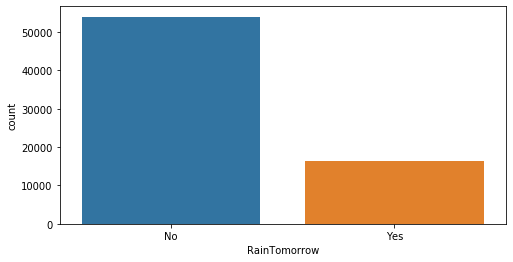

In [11]:
fig, ax = plt.subplots(figsize=(8, 4))
ax = sns.countplot(x="RainTomorrow", data=train)
plt.show()

In [12]:
# Гиперпараметрыx
columns_to_fix = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustSpeed',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm']
drop_quantile = 0.25

In [16]:
# Заведем удобную перемнную
train_fixed= train.copy()
test_fixed= test.copy()

# Закодируем колонку RainTomorrow
encoder = LE()
encoder.fit(train['RainTomorrow'])
train_fixed['RainTomorrow'] = encoder.transform(train_fixed['RainTomorrow'])

# В колонке Pressure могли встретиться такие значения, как 1,00E+3,
# что нужно было исправить
columns_to_fix_format = ['Pressure9am', 'Pressure3pm']

for column in columns_to_fix_format:
    train_fixed[column] = train_fixed[column].apply(
        lambda x: str(x).replace(',', '.')).astype('float64')
    test_fixed[column] = test_fixed[column].apply(
        lambda x: str(x).replace(',', '.')).astype('float64')

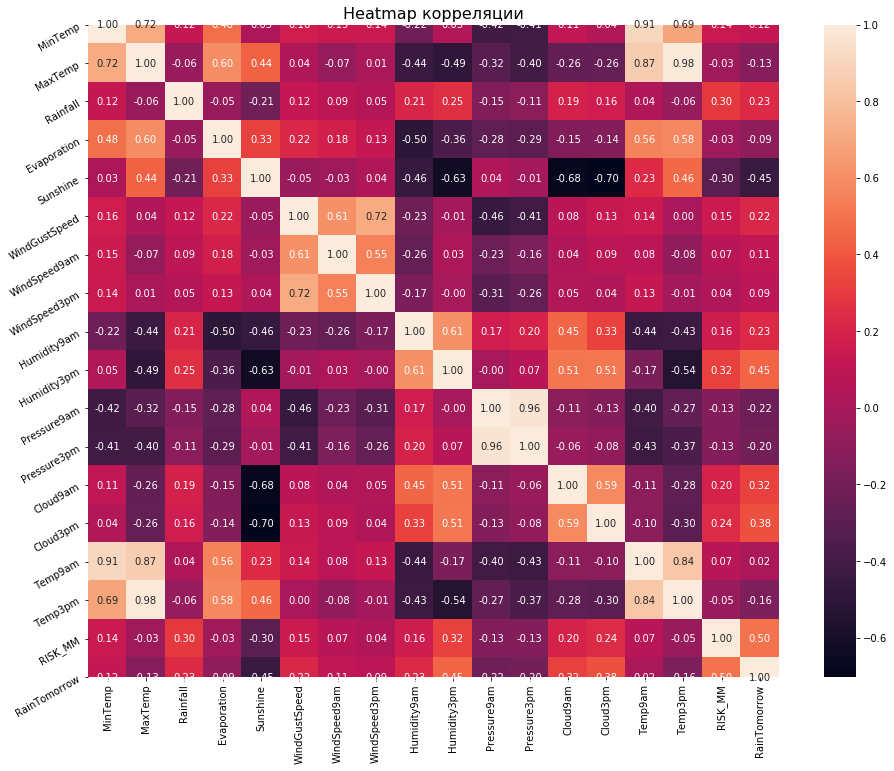

In [17]:
plt.figure(figsize=(16,12))
plt.title('Heatmap корреляции', fontsize=16)
ax = sns.heatmap(train_fixed.corr(), square=True, annot=True, fmt='.2f', linecolor='white')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticklabels(ax.get_yticklabels(), rotation=30)           
plt.show()

In [18]:
def toFixed(numObj, digits=0):
    return f"{numObj:.{digits}f}"

# Поищем большое влияние со стороны переменных
for name in columns_to_fix:
    for n in range(int(train_fixed[name].min()), int(train_fixed[name].max()), 5):
        perc = train_fixed[train_fixed[name] > n][train_fixed['RainTomorrow'] == 1].shape[0] / train_fixed[train_fixed[name] > n].shape[0];
        if (perc > 0.80):
            print("Если \'", name, "\' имеет значение более ", n, " шанс завтрашнего дождя  ", toFixed(perc*100, 4), '%', sep = '')
            break

Если 'Rainfall' имеет значение более 160 шанс завтрашнего дождя  81.2500%
Если 'WindGustSpeed' имеет значение более 127 шанс завтрашнего дождя  100.0000%
Если 'Humidity3pm' имеет значение более 86 шанс завтрашнего дождя  82.3082%


# Outliers и NaN

In [27]:
# Справляемся с NaN и аномалиями в данных
for column in columns_to_fix:
    IQR = train_fixed[column].quantile(1 - drop_quantile) - train_fixed[column].quantile(drop_quantile)
    lower_limit = train_fixed[column].quantile(drop_quantile) - (IQR * 3)
    upper_limit = train_fixed[column].quantile(1 - drop_quantile) + (IQR * 3)
    
    train_fixed[column].fillna(
        train_fixed[column].mean(), inplace = True)
    test_fixed[column].fillna(
        train_fixed[column].mean(), inplace = True)

    train_quant = train_fixed[train_fixed[column] < lower_limit]
    train_fixed.drop(train_quant.index, inplace = True)
    
    test_quant = test_fixed[test_fixed[column] < lower_limit]
    test_fixed.drop(test_quant.index, inplace = True)
    
    train_quant = train_fixed[train_fixed[column] > upper_limit]
    train_fixed.drop(train_quant.index, inplace = True)
    
    test_quant = test_fixed[test_fixed[column] > upper_limit]
    test_fixed.drop(test_quant.index, inplace = True)

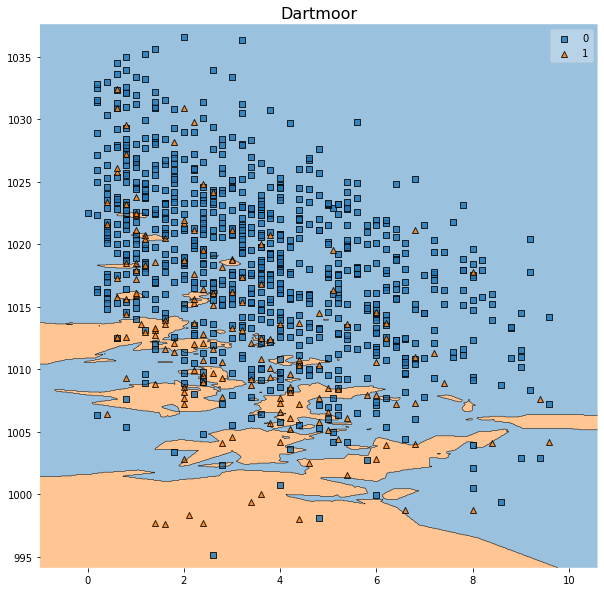

In [43]:
# Гиперпараметры
columns_to_check = ['Evaporation', 'Pressure3pm']
assert len(columns_to_check) == 2

# График с kNN, обученном на двух параметрах в случайной локации
fig = plt.figure(figsize=(10,10))
name = train_fixed['Location'].unique()[np.random.randint(train_fixed['Location'].unique().shape[0])]

X = train_fixed[train_fixed['Location'] == name].sort_values(by = ['Date'])

if (X.shape[0] != 0):
    knn = KNeighborsClassifier()
    knn.fit(X[columns_to_check].values, X['RainTomorrow'].values)

    plot_decision_regions(X[columns_to_check].values, 
                          X['RainTomorrow'].values, clf = knn)
    plt.title(name, fontsize = 16)
    
plt.show()

**Замечание**: по двум параметрам с помощью kNN получается хороший минимализм, но плохой data science

# Encodings

In [30]:
to_dummies = ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']

X_train = pd.concat([train_fixed[columns_to_fix]] + [
    pd.get_dummies(train_fixed[i]) for i in to_dummies], axis = 1)
X_test = pd.concat([test_fixed[columns_to_fix]] + [
    pd.get_dummies(test_fixed[i]) for i in to_dummies], axis = 1)

y_train = train_fixed['RainTomorrow']

# Training

In [31]:
logreg = LogisticRegression(solver='liblinear', random_state=0)
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [34]:
print('Training set score: {:.4f}'.format(logreg.score(X_train, y_train)))

Training set score: 0.8820


In [33]:
pd.DataFrame(logreg.predict(X_test)).to_csv("res.csv", index = False)